# 라이브러리 불러오기

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.layers import TimeDistributed as TD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 전역변수
IMG_SIZE = 168
MAX_SEQ_LENGTH = 20
BATCH_SIZE = 32

In [4]:
# git clone
! git clone https://github.com/metal3d/keras-video-generators.git

# 다운로드한 폴더로 이동
os.chdir("/content/keras-video-generators/")

# git 컴파일
! python setup.py build

# 폴더 생성
! mkdir /content/keras_video

# git 파일 복사 /content/keras_video
! cp /content/keras-video-generators/build/lib/keras_video/*.*  /content/keras_video

import keras_video.utils
from keras_video import VideoFrameGenerator

Cloning into 'keras-video-generators'...
remote: Enumerating objects: 614, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 614 (delta 47), reused 75 (delta 35), pack-reused 514
Receiving objects: 100% (614/614), 7.77 MiB | 11.34 MiB/s, done.
Resolving deltas: 100% (279/279), done.
/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'licence_file'
  warnings.warn(msg)
running build
running build_py
creating build
creating build/lib
creating build/lib/keras_video
copying src/keras_video/utils.py -> build/lib/keras_video
copying src/keras_video/sliding.py -> build/lib/keras_video
copying src/keras_video/__init__.py -> build/lib/keras_video
copying src/keras_video/flow.py -> build/lib/keras_video
copying src/keras_video/generator.py -> build/lib/keras_video


# 데이터 전처리

In [5]:
# 데이터 불러오기
data_path = '/content/drive/MyDrive/모듈프로젝트4_3조/16.모듈프로젝트04/workspace/'
train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')

In [6]:
classes = train_df['tag'].unique().tolist()
classes = sorted(classes)

In [7]:
# 라벨 인코딩 : 'label' 컬럼 따로 만들지 않고 'tag'에 바로 대입함
# {CricketShot: 0, Punch: 1, TennisSwing: 2}
encoder = LabelEncoder()
train_df['tag'] = encoder.fit_transform(train_df['tag'])
test_df['tag'] = encoder.transform(test_df['tag'])

In [8]:
# 비디오를 구성하는 이미지의 가운데 부분을 리턴
def crop_center_square(frame):
    y, x = frame.shape[:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [9]:
# 비디오 파일을 읽어서 각 프레임을 이미지로 변환해서 리턴
def load_video(path, max_frames=MAX_SEQ_LENGTH, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = list()
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [10]:
# 모든 비디오 파일의 이미지와 종류를 리턴
def prepare_all_videos(video_name, label, root_dir):
    num_samples = len(video_name)
    video_paths = video_name.values.tolist()
    labels = label.values.reshape(-1, 1)

    x = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype='float32')
    y = np.array(labels , dtype='float32')

    for video_index, path in enumerate(video_paths):
        print(f'\rprepare all videos : {video_index + 1} / {num_samples}', end='')
        video = np.zeros(shape=(MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype='float32')
        frames = load_video(root_dir + path)
        for i in range(len(frames)):
            video[i] = frames[i] / 255
        x[video_index] = video
    print()

    return x, to_categorical(y)

In [11]:
# train 및 test 데이터셋 생성
x_train, y_train = prepare_all_videos(train_df['video_name'], train_df['tag'], '/content/drive/MyDrive/모듈프로젝트4_3조/16.모듈프로젝트04/workspace/train/')
x_test, y_test = prepare_all_videos(test_df['video_name'], test_df['tag'], '/content/drive/MyDrive/모듈프로젝트4_3조/16.모듈프로젝트04/workspace/test/')

prepare all videos : 356 / 356
prepare all videos : 137 / 137


# 데이터 분석
데이터 전처리 부분이 중복되어 base_model, vgg16_model, resnet50_model을 같이 썼습니다.

## 공통 부분

In [12]:
# 비디오 프레임의 이미지를 변형 할 객체 변형할 객체
train_image_data_gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,       # 이미지 회전 각도 최대 30도
	zoom_range=0.15,         # 이미지 확대 비율 
	width_shift_range=0.2,   # 이미지 가로 이동 비율
	height_shift_range=0.2,  # 이미지 세로 이동 비율
	shear_range=0.15,        # 이미지 기울기 비율
	horizontal_flip=True,    # 이미지 좌우 반전을 가능하도록 설정
	fill_mode="nearest",     # 이미지를 회전 이동시 빈공간을 채우는 방식
)

In [13]:
glob_pattern = data_path + 'train/v_{classname}_*.avi'
SIZE = (IMG_SIZE, IMG_SIZE)
CHANNELS = 3

# 비디오 프레임 20개 생성할 객체
train_video_generator = VideoFrameGenerator(
    classes=classes,                      # 분류할 클래스 설정 : ['CricketShot', 'Punch', 'TennisSwing']
    glob_pattern=glob_pattern,            # 파일명에서 클래스 정보를 따옴
    nb_frames=20,                         # 시퀀스의 프레임의 수 
    split=0.33,                           # 검증용 파일로 나눌 분할 비율 
    shuffle=True,                         # 섞을 것 인지 
    batch_size=2,                         # 배치 사이즈는 2로 설정 한 배치의 시퀀스 수
    target_shape=SIZE,                    # 요소 2에서 만든 (224,224)
    nb_channel=CHANNELS,                  # 요소 2에서 만든 3  3이니까 RGB 채널 
    transformation=train_image_data_gen,  # 요소 3에서 만든 비디오 프레임의 변형 
    use_frame_cache=True                  # 프레임 캐시를 사용할지 여부 / 사용을 위해 다량의 메모리 필요 
)

test_image_data_generator = ImageDataGenerator(
    rescale=1/255
)

Total data: 3 classes for 356 files for train


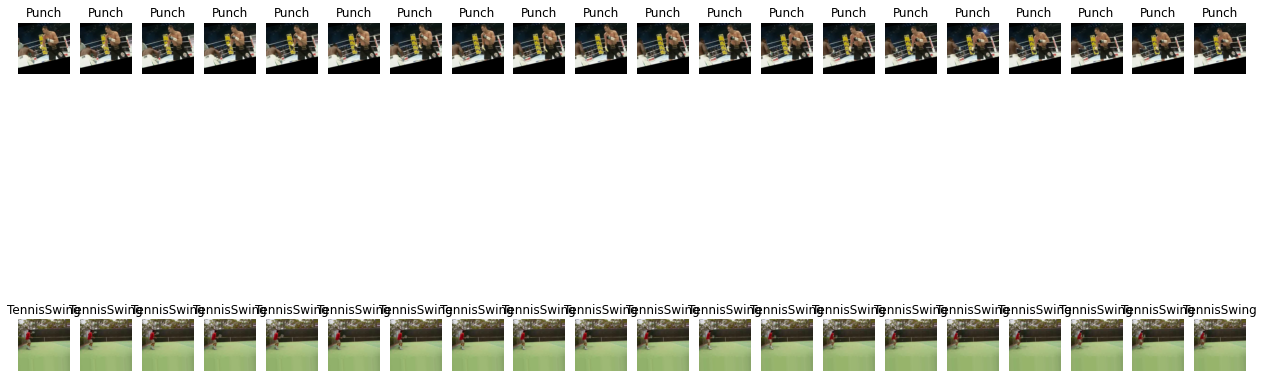

In [14]:
keras_video.utils.show_sample(train_video_generator)

# checkpoint는 생략했습니다.

In [15]:
# callbacks

# ealry_stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',               # 무엇을 감시하고 있을지
    min_delta=1e-4,               # 개선이 되는 것으로 보는 최소값, 이 값보다 작으면 개선이 없는 것
    patience=5,                   # patience의 epochs만큼 진행해도 개선되지 않으면 중단
)

# checkpoint
checkpoint_filepath = "/content/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

## LSTM 모델

In [16]:
# LSTM 모델 정의 (lstm_model)
lstm_model = Sequential([
    TD(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='SAME'), input_shape=(20, IMG_SIZE, IMG_SIZE, 3)),
    TD(MaxPooling2D(pool_size=2, padding='SAME', strides=2)),
    TD(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='SAME')),
    TD(MaxPooling2D(pool_size=2, padding='SAME', strides=2)),
    TD(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='SAME')),
    TD(MaxPooling2D(pool_size=2, padding='SAME', strides=2)),
    TD(Flatten()),
    Dropout(0.5),
    LSTM(128, dropout=0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['acc'])

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 168, 168, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 84, 84, 32)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 84, 84, 64)    18496     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 42, 42, 64)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 42, 42, 128)   73856     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 21, 21, 128)   0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 56448)         0

In [ ]:
# LSTM 모델 학습
best_val_acc = [0, 0]
for i in range(20):
    print(i+1, '번째 학습 결과입니다.')
    lstm_model.fit(
        train_video_generator, batch_size=1, epochs=3
    )
    print(i+1, '번째 평가 결과입니다.')
    result = lstm_model.evaluate(x_test, y_test)
    if result[1] > best_val_acc[1]:
        best_val_acc = [i, result[1]]
    print()

1 번째 학습 결과입니다.
Epoch 1/3
178/178 [==============================] - 96s 352ms/step - loss: 1.1702 - acc: 0.3455
Epoch 2/3
178/178 [==============================] - 55s 309ms/step - loss: 1.0275 - acc: 0.4944
Epoch 3/3
178/178 [==============================] - 55s 307ms/step - loss: 1.0065 - acc: 0.4775
1 번째 평가 결과입니다.
5/5 [==============================] - 10s 737ms/step - loss: 1.0684 - acc: 0.4015

2 번째 학습 결과입니다.
Epoch 1/3
178/178 [==============================] - 55s 306ms/step - loss: 0.8864 - acc: 0.6236
Epoch 2/3
178/178 [==============================] - 55s 308ms/step - loss: 0.8077 - acc: 0.6517
Epoch 3/3
178/178 [==============================] - 55s 309ms/step - loss: 0.7693 - acc: 0.6601
2 번째 평가 결과입니다.
5/5 [==============================] - 2s 302ms/step - loss: 0.8485 - acc: 0.6058

3 번째 학습 결과입니다.
Epoch 1/3
178/178 [==============================] - 55s 311ms/step - loss: 0.7195 - acc: 0.7079
Epoch 2/3
178/178 [==============================] - 55s 310ms/step - loss: 0.8

In [ ]:
# LSTM 모델 학습
# lstm_model.fit(
#     train_video_generator, batch_size=1, epochs=100, callbacks=[early_stopping]
# )

In [ ]:
# LSTM 모델 평가
# lstm_model.evaluate(x_test, y_test)

In [ ]:
# LSTM 모델 평가 : 코드 캡쳐할까봐 일단 남겨놔요
# lstm_model.evaluate(x_test, y_test)

In [ ]:
lstm_model.save('/content/drive/MyDrive/모듈프로젝트4_3조/김남준/models/lstm_model.h5')
# del lstm_model

## GRU 모델
형태는 LSTM 모델과 동일합니다.

In [ ]:
# # GRU 모델 정의 (gru_model)
# gru_model = Sequential([
#     TD(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='SAME'), input_shape=(20, IMG_SIZE, IMG_SIZE, 3)),
#     TD(MaxPooling2D(pool_size=2, padding='SAME', strides=2)),
#     TD(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='SAME')),
#     TD(MaxPooling2D(pool_size=2, padding='SAME', strides=2)),
#     TD(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='SAME')),
#     TD(MaxPooling2D(pool_size=2, padding='SAME', strides=2)),
#     TD(Flatten()),
#     Dropout(0.5),
#     GRU(128, dropout=0.5),
#     Dense(64, activation='relu'),
#     Dropout(0.5),
#     Dense(3, activation='softmax')
# ])

# gru_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['acc'])

# gru_model.summary()

In [ ]:
# # GRU 모델 학습
# for i in range(20):
#     print(i+1, '번째 학습 결과입니다.')
#     gru_model.fit(
#         train_video_generator, batch_size=1, epochs=5
#     )
#     print(i+1, '번째 평가 결과입니다.')
#     gru_model.evaluate(x_test, y_test)
#     print()

In [ ]:
# GRU 모델 학습
# gru_model.fit(
#     train_video_generator, batch_size=1, epochs=100, callbacks=[early_stopping]
# )

In [ ]:
# GRU 모델 평가
# gru_model.evaluate(x_test, y_test)

In [ ]:
# gru_model.save('/content/drive/MyDrive/모듈프로젝트4_3조/김남준/models/gru_model.h5')
# del gru_model